# Implementation of Deep Convolutional GANs
Reference: https://arxiv.org/pdf/1511.06434.pdf

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter

In [4]:
import numpy as np
import datetime
import os, sys
from tqdm import tqdm_notebook as tqdm

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z) # (100, 1, 28, 28)
    result = y_hat.view(100, 28, 28).cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img, y_hat

In [8]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
        )
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, y=None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [9]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 4*4*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential( # upsampling
            # input: 4 by 4, output: 7 by 7
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 512, 4, 4)
        y_ = self.conv(y_)
        return y_

In [10]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

In [11]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [12]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [13]:
batch_size = 64

In [15]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, num_workers=16, shuffle=True, drop_last=True)

In [16]:
from itertools import product
parameters = dict(
    lr = [0.001],
    n_critic = [1]
)
param_values = [v for v in parameters.values()]


In [17]:
criterion = nn.BCELoss()

In [18]:
max_epoch = 100 # need more than 20 epochs for training generator
n_noise = 100

In [19]:
image, _ = next(iter(data_loader))
grid = torchvision.utils.make_grid(image)
#tb.add_graph(D, image)

In [20]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [21]:
D_x_loss_full, D_z_loss_full, D_loss_full, G_loss_full = 0,0,0,0
for lr, nc in product(*param_values): 
    D = Discriminator().to(DEVICE)
    G = Generator().to(DEVICE)
    D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
    G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    n_critic = nc # for training more k steps about Discriminator
    comment = f'{MODEL_NAME} batch_size={batch_size} lr=0.0002,{lr} n_critic={n_critic}'
    if not os.path.exists(f'samples/{comment}'): os.makedirs(f'samples/{comment}')
    tb = SummaryWriter(comment=comment)
    tb.add_image('images',grid)
    step = 0
    for epoch in tqdm(range(max_epoch)):
        for idx, (images, _) in enumerate(data_loader):
            # Training Discriminator
            x = images.to(DEVICE)
            x_outputs = D(x)
            D_x_loss = criterion(x_outputs, D_labels) # to true label loss
            D_x_loss_full += D_x_loss

            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            D_z_loss = criterion(z_outputs, D_fakes) # to fake label loss
            D_loss = D_x_loss + D_z_loss
            D_z_loss_full += D_z_loss
            D_loss_full += D_loss

            D_opt.zero_grad()
            D_loss.backward()
            D_opt.step()

            if step % n_critic == 0:
                # Training Generator
                z = torch.randn(batch_size, n_noise).to(DEVICE)
                z_outputs = D(G(z))
                G_loss = criterion(z_outputs, D_labels) # to true label loss
                G_loss_full += G_loss

                G_opt.zero_grad()
                G_loss.backward()
                G_opt.step()

            if step % 500 == 0:
                print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
                if step > 0:
                    tb.add_scalars('losses', {
                        'D_x_loss': D_x_loss_full/500,
                        'D_z_loss': D_z_loss_full/500,
                        'D_loss': D_loss_full/500,
                        'G_loss': G_loss_full/500*n_critic
                    }, step)
                    tb.add_scalar('D_x_loss', D_x_loss_full/500, step)
                    D_x_loss_full = 0
                    tb.add_scalar('D_z_loss', D_z_loss_full/500, step)
                    D_z_loss_full = 0
                    tb.add_scalar('D_loss', D_loss_full/500, step)
                    D_loss_full = 0
                    tb.add_scalar('G_loss', G_loss_full/500*n_critic, step)
                    G_loss_full = 0
                else:
                    tb.add_scalars('losses', {
                        'D_x_loss': D_x_loss_full,
                        'D_z_loss': D_z_loss_full,
                        'D_loss': D_loss_full,
                        'G_loss': G_loss_full
                    }, step)
                    tb.add_scalar('D_x_loss', D_x_loss_full, step)
                    tb.add_scalar('D_z_loss', D_z_loss_full, step)
                    tb.add_scalar('D_loss', D_loss_full, step)
                    tb.add_scalar('G_loss', G_loss_full, step)

                for name, weight in D.named_parameters():
                    tb.add_histogram(name, weight, epoch)
                    tb.add_histogram(f'{name}.grad', weight.grad, epoch)

            if step % 2000 == 0:
                G.eval()
                img, y_hat = get_sample_image(G, n_noise)
                grid = torchvision.utils.make_grid(y_hat)
                tb.add_image(f'step_{step}', grid)
                imsave('samples/{}/{}_step{}.jpg'.format(comment, MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
                G.train()
            step += 1

Epoch: 0/100, Step: 0, D Loss: 1.3804218769073486, G Loss: 0.7133513689041138
Epoch: 0/100, Step: 500, D Loss: 1.0729868412017822, G Loss: 0.8816018104553223
Epoch: 1/100, Step: 1000, D Loss: 1.1735618114471436, G Loss: 1.183627724647522
Epoch: 1/100, Step: 1500, D Loss: 1.12717604637146, G Loss: 0.9420187473297119
Epoch: 2/100, Step: 2000, D Loss: 1.1233429908752441, G Loss: 1.0345330238342285
Epoch: 2/100, Step: 2500, D Loss: 0.8916980028152466, G Loss: 1.1802432537078857
Epoch: 3/100, Step: 3000, D Loss: 0.9536949396133423, G Loss: 0.8442351818084717
Epoch: 3/100, Step: 3500, D Loss: 1.0016138553619385, G Loss: 1.441192865371704
Epoch: 4/100, Step: 4000, D Loss: 1.0343832969665527, G Loss: 1.3200480937957764
Epoch: 4/100, Step: 4500, D Loss: 0.9812076091766357, G Loss: 1.1752564907073975
Epoch: 5/100, Step: 5000, D Loss: 0.9734280109405518, G Loss: 0.9579102993011475
Epoch: 5/100, Step: 5500, D Loss: 0.9310612082481384, G Loss: 1.579223394393921
Epoch: 6/100, Step: 6000, D Loss: 0.9

Epoch: 53/100, Step: 50000, D Loss: 0.6286411285400391, G Loss: 1.7163039445877075
Epoch: 53/100, Step: 50500, D Loss: 0.9815624952316284, G Loss: 2.5046186447143555
Epoch: 54/100, Step: 51000, D Loss: 0.4826280474662781, G Loss: 1.188743233680725
Epoch: 54/100, Step: 51500, D Loss: 0.8324460983276367, G Loss: 1.2125186920166016
Epoch: 55/100, Step: 52000, D Loss: 0.7167613506317139, G Loss: 3.1616032123565674
Epoch: 56/100, Step: 52500, D Loss: 1.100226879119873, G Loss: 3.0584585666656494
Epoch: 56/100, Step: 53000, D Loss: 0.6264567375183105, G Loss: 1.3209095001220703
Epoch: 57/100, Step: 53500, D Loss: 0.6786563992500305, G Loss: 2.3817906379699707
Epoch: 57/100, Step: 54000, D Loss: 0.31734418869018555, G Loss: 1.6064975261688232
Epoch: 58/100, Step: 54500, D Loss: 0.6189221143722534, G Loss: 1.0234925746917725
Epoch: 58/100, Step: 55000, D Loss: 0.5543351173400879, G Loss: 2.112746477127075
Epoch: 59/100, Step: 55500, D Loss: 0.3939827084541321, G Loss: 1.648221492767334
Epoch: 

## Sample

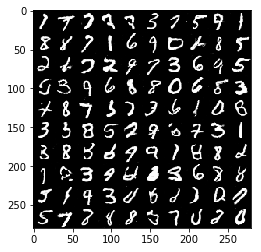

In [18]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [15]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [16]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_dc.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_dc.pth.tar')